<a href="https://colab.research.google.com/github/praseedm/tracin_implemention_on_ledgar_dataset/blob/main/Train_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone git repo for data
! git clone https://github.com/praseedm/tracin_implemention_on_ledgar_dataset.git

Cloning into 'tracin_implemention_on_ledgar_dataset'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 33 (delta 10), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [2]:
%cd tracin_implemention_on_ledgar_dataset

/content/tracin_implemention_on_ledgar_dataset


In [37]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 462 kB 48.1 MB/s 


In [38]:
import os

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_text as text
import pandas as pd
import json


tf.get_logger().setLevel('ERROR')

In [4]:
tf.__version__

'2.8.0'

## Data preparation

In [5]:
BATCH_SIZE = 32
SEED = 10
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
train_data_path = './data/train_data.csv'
train_df = pd.read_csv(train_data_path)
print(train_df.shape)
train_df.head(3)

(32906, 2)


,text,label
0,Except as otherwise set forth in this Debentur...,24
1,This Amendment may be executed by one or more ...,4
2,"From time to time, as and when required by the...",8


In [74]:
def generate_batch_dataset_from_csv(csv_path:str):
  df = pd.read_csv(csv_path)
  dataset = tf.data.Dataset.from_tensor_slices(
      (
          df['text'].values,
          df['label'].values
      )
  )
  print(f"{len(dataset)}\n{dataset.element_spec}")
  return dataset.batch(batch_size=BATCH_SIZE)

In [75]:
train_ds = generate_batch_dataset_from_csv(csv_path='./data/train_data.csv')

32906
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [78]:
validation_ds = generate_batch_dataset_from_csv(csv_path='./data/validation_data.csv')
test_ds = generate_batch_dataset_from_csv(csv_path='./data/test_data.csv')

5465
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
5438
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [79]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
# Load labels 
with open('./data/label_names.json') as rb:
  label_names = json.load(rb)
print(f"Loaded {len(label_names)} labels")
print(f"Labels : {label_names}")

Loaded 25 labels
Labels : ['Amendments', 'Assignments', 'Compliance With Laws', 'Confidentiality', 'Counterparts', 'Entire Agreements', 'Expenses', 'Financial Statements', 'Further Assurances', 'General', 'Governing Laws', 'Indemnifications', 'Insurances', 'Litigations', 'No Conflicts', 'Notices', 'Payments', 'Severability', 'Survival', 'Taxes', 'Terminations', 'Terms', 'Use Of Proceeds', 'Waiver Of Jury Trials', 'Waivers']


In [77]:
# Print sample data
for texts, labels in train_ds.take(1):
  for i in range(4):
    print(f"Text : {texts[i]}")
    print(f"Label : {label_names[labels[i]]}")

Text : b'Except as otherwise set forth in this Debenture, the Company, for itself and its legal representatives, successors and assigns, expressly waives presentment, protest, demand, notice of dishonor, notice of nonpayment, notice of maturity, notice of protest, presentment for the purpose of accelerating maturity, and diligence in collection.'
Label : Waivers
Text : b'This Amendment may be executed by one or more of the parties hereto on any number of separate counterparts, and all of said counterparts taken together shall be deemed to constitute one and the same instrument. This Amendment may be delivered by facsimile or other electronic transmission of the relevant signature pages hereof.'
Label : Counterparts
Text : b'From time to time, as and when required by the Surviving Corporation or by its successors or assigns, there shall be executed and delivered on behalf of Ashford (DE) such deeds and other instruments, and there shall be taken or caused to be taken by it all such furt

## BERT Config
[BERT TF Hub](https://tfhub.dev/google/collections/bert/1)

In [31]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

In [63]:
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='BERT_preprocessing')
  preprocessed_text = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(preprocessed_text)
  x = outputs['pooled_output']
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Dense(len(label_names), activation=None, name='output')(x)
  return tf.keras.Model(text_input, x)

In [64]:
model = build_model()

In [65]:
# Test model
tf.nn.softmax(model(tf.constant(["hellow world"])))

<tf.Tensor: shape=(1, 25), dtype=float32, numpy=
array([[0.00263023, 0.00909449, 0.01549286, 0.00769024, 0.0105154 ,
        0.08959267, 0.02780486, 0.01177379, 0.08516105, 0.06210374,
        0.03112318, 0.00358649, 0.11171715, 0.01049555, 0.05340417,
        0.03783984, 0.04389706, 0.00848033, 0.02398726, 0.01606006,
        0.01651335, 0.17228754, 0.00563249, 0.00252   , 0.14059621]],
      dtype=float32)>

In [66]:
# Print the model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 BERT_preprocessing (KerasLayer  {'input_mask': (Non  0          ['input[0][0]']                  
 )                              e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

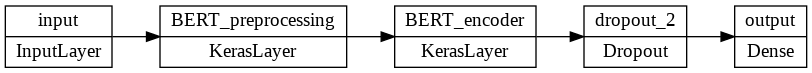

In [67]:
tf.keras.utils.plot_model(model, rankdir='LR')

In [87]:
# compiling model
model.compile(optimizer='sgd',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['sparse_categorical_accuracy'])

## Train model

In [ ]:
EPOCHS=10
history = model.fit(train_ds,validation_data=validation_ds, epochs=EPOCHS)

Epoch 1/10
 721/1029 [====================>.........] - ETA: 2:07 - loss: 0.6461 - sparse_categorical_accuracy: 0.8398